In [1]:
import pandas as pd
from IPython.display import display

red_wine = pd.read_csv('./red-wine.csv')

In [13]:
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)

max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)

df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

X_train = df_train.drop(['quality'], axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

In [4]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, patience=20, restore_best_weights=True
)

In [5]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[11]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(optimizer='adam', loss='mae')

2023-05-05 16:51:16.172380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-05 16:51:16.172453: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-05 16:51:16.172507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thomas-Lenovo-V15-G2-ALC): /proc/driver/nvidia/version does not exist
2023-05-05 16:51:16.173636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
history = model.fit(X_train, y_train, validation_data=[X_valid, y_valid], batch_size=256, epochs=500, callbacks=[early_stopping], verbose=0)

In [16]:
history_df = pd.DataFrame(history.history)
history_df

,loss,val_loss
0,0.156130,0.144171
1,0.129658,0.129423
2,0.120646,0.126268
3,0.114485,0.109916
4,0.109779,0.109040
...,...,...
60,0.077156,0.092207
61,0.075743,0.091946
62,0.077040,0.095270
63,0.083113,0.092616


Minimum validation loss: 0.09067848324775696


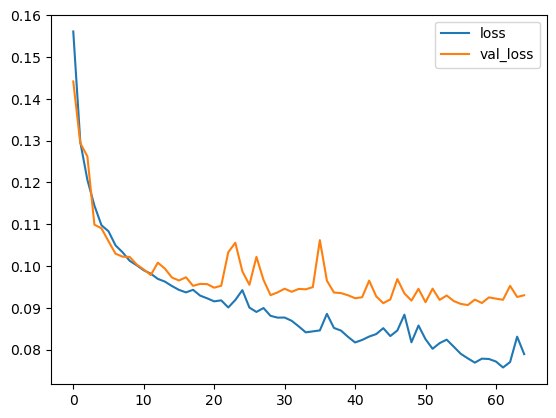

In [22]:
history_df.loc[:, :].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [23]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [25]:
spotify = pd.read_csv('./spotify.csv')
spotify

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.102000,0.000000,0.0653,0.5180,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.072400,0.004210,0.3570,0.6930,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.079400,0.000023,0.1100,0.6130,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.028700,0.000009,0.2040,0.2770,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.080300,0.000000,0.0833,0.7250,123.976,189052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,Lush & Simon,42,2azRoBBWEEEYhqV6sb7JrT,City Of Lights (Vocal Mix),2014-04-28,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,2,-1.814,1,0.0936,0.076600,0.000000,0.0668,0.2100,128.170,204375
32829,5Aevni09Em4575077nkWHz,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,20,6kD6KLxj7s8eCE3ABvAyf5,Closer Remixed,2013-03-08,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,0,-4.462,1,0.0420,0.001710,0.004270,0.3750,0.4000,128.041,353120
32830,7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,14,0ltWNSY9JgxoIZO4VzuCa6,Sweet Surrender (Radio Edit),2014-04-21,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,6,-4.899,0,0.0481,0.108000,0.000001,0.1500,0.4360,127.989,210112
32831,2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Mat Zo,15,1fGrOkHnHJcStl14zNx8Jy,Only For You (Remixes),2014-01-01,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,2,-3.361,1,0.1090,0.007920,0.127000,0.3430,0.3080,128.008,367432


In [26]:
X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

In [27]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']


In [28]:
preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

In [29]:
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

In [30]:
X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

In [31]:
X_train

,track_id,track_name,track_artist,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,6,-2.634,1,0.0583,0.102000,0.000000,0.0653,0.5180,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,11,-4.969,1,0.0373,0.072400,0.004210,0.3570,0.6930,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,1,-3.432,0,0.0742,0.079400,0.000023,0.1100,0.6130,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,7,-3.778,1,0.1020,0.028700,0.000009,0.2040,0.2770,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,1,-4.672,1,0.0359,0.080300,0.000000,0.0833,0.7250,123.976,189052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32827,0aBDrRTgDCwWbcOnEIp7DJ,Many Ways - Radio Edit,Ferry Corsten feat. Jenny Wahlstrom,59XOfNjuYZB6feC6QUzS3e,Many Ways,2013,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,progressive electro house,...,5,-8.367,1,0.0365,0.026600,0.000000,0.5720,0.2880,128.001,196993
32828,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,Lush & Simon,2azRoBBWEEEYhqV6sb7JrT,City Of Lights (Vocal Mix),2014-04-28,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,progressive electro house,...,2,-1.814,1,0.0936,0.076600,0.000000,0.0668,0.2100,128.170,204375
32830,7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,0ltWNSY9JgxoIZO4VzuCa6,Sweet Surrender (Radio Edit),2014-04-21,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,progressive electro house,...,6,-4.899,0,0.0481,0.108000,0.000001,0.1500,0.4360,127.989,210112
32831,2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Mat Zo,1fGrOkHnHJcStl14zNx8Jy,Only For You (Remixes),2014-01-01,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,progressive electro house,...,2,-3.361,1,0.1090,0.007920,0.127000,0.3430,0.3080,128.008,367432


In [32]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

In [33]:
input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


In [34]:
model = keras.Sequential([
    layers.Dense(1, input_shape = input_shape),
])

model.compile(
    optimizer = 'adam',
    loss = 'mae'
)

history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid) ,batch_size=512, epochs=50, verbose=0)

Minimum Validation Loss: 0.1936


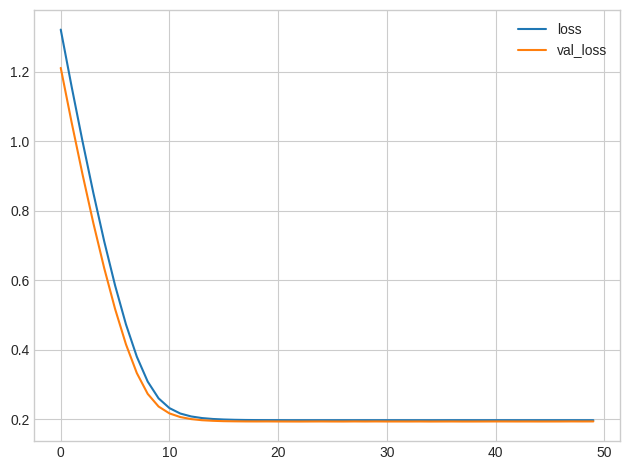

In [36]:
history_df = pd.DataFrame(history.history)
history_df.plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

<AxesSubplot:>

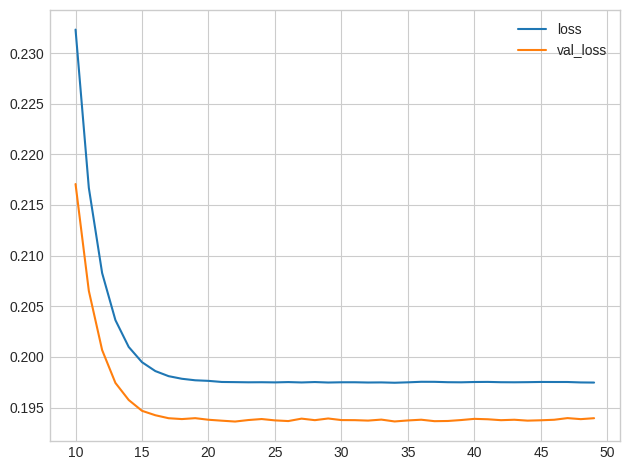

In [38]:
history_df.loc[10:].plot()

Epoch 1/50
49/49 [==============================] - 1s 5ms/step - loss: 0.2369 - val_loss: 0.2031
Epoch 2/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2011 - val_loss: 0.1980
Epoch 3/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1969 - val_loss: 0.1965
Epoch 4/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1940 - val_loss: 0.1971
Epoch 5/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1917 - val_loss: 0.1945
Epoch 6/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1912 - val_loss: 0.1945
Epoch 7/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1889 - val_loss: 0.1950
Epoch 8/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1878 - val_loss: 0.1957
Epoch 9/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1873 - val_loss: 0.1948
Epoch 10/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1864 - val_loss: 0.1950
Epoch 11/50
49/49 [

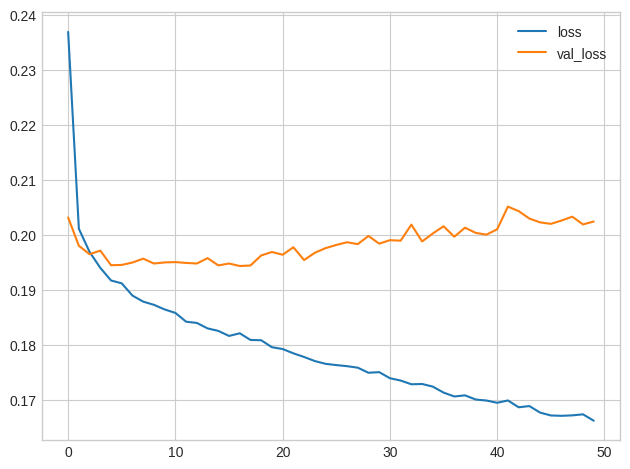

In [39]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer = 'adam',
    loss = 'mae'
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [40]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, patience=5, restore_best_weights=True
)

Epoch 1/50
49/49 [==============================] - 1s 6ms/step - loss: 0.2550 - val_loss: 0.2068
Epoch 2/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2033 - val_loss: 0.2000
Epoch 3/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1978 - val_loss: 0.1973
Epoch 4/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1950 - val_loss: 0.1964
Epoch 5/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1927 - val_loss: 0.1963
Epoch 6/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1910 - val_loss: 0.1958
Epoch 7/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1902 - val_loss: 0.1955
Epoch 8/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1893 - val_loss: 0.1937
Epoch 9/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1879 - val_loss: 0.1932
Epoch 10/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1866 - val_loss: 0.1944
Epoch 11/50
49/49 [

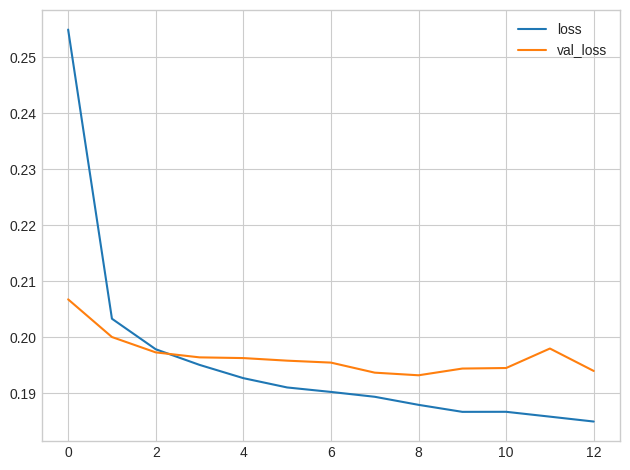

In [41]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));